<a href="https://colab.research.google.com/github/jasika1909/E-Commerece-Clone/blob/main/PS_25091_solu(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1:** Install dependencies

In [1]:
!pip install ortools pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 w

# **Step 2:** Create datasets

In [2]:
import pandas as pd

# Courses: id, name, sessions_per_week, expected_students, faculty_id, is_lab
courses = pd.DataFrame([
    ["CSE101","Intro to CS",4,120,"F1",0],
    ["CSE102","Data Structures",4,80,"F2",0],
    ["CSE103","Digital Logic Lab",2,30,"F3",1],
    ["CSE104","Math for CS",3,100,"F4",0],
    ["CSE105","Elective-AI",2,60,"F5",0],
], columns=["course_id","name","sessions_per_week","expected_students","faculty_id","is_lab"])

# Faculties
faculty = pd.DataFrame([
    ["F1","Dr. A",6,""],
    ["F2","Dr. B",6,"2,3"],
    ["F3","Dr. C",4,""],
    ["F4","Dr. D",5,"5"],
    ["F5","Dr. E",4,""],
], columns=["faculty_id","name","max_hours_per_day","unavailable_slots"])

# Rooms
rooms = pd.DataFrame([
    ["R1",150,0],
    ["R2",80,0],
    ["R3",40,1],  # lab
    ["R4",60,0],
], columns=["room_id","capacity","is_lab"])

# Slots (Mon–Fri, 6 per day)
slots = []
days = ["Mon","Tue","Wed","Thu","Fri"]
slot_id = 0
for d in days:
    for s in range(1,7):  # 6 slots/day
        slot_id += 1
        slots.append([slot_id, d, s])
slots = pd.DataFrame(slots, columns=["slot_id","day","slot_no"])

# Enrollments
enrollments = pd.DataFrame([
    ["CSE101","B1"],
    ["CSE102","B1"],
    ["CSE103","B1"],
    ["CSE104","B1"],
    ["CSE105","B1"],
], columns=["course_id","batch_id"])

print("✅ Datasets ready")


✅ Datasets ready


# **Step 3:** Solver code

In [3]:
from ortools.sat.python import cp_model

def solve_timetable(courses, faculty, rooms, slots, enrollments):
    model = cp_model.CpModel()

    course_ids = list(courses["course_id"])
    slot_ids = list(slots["slot_id"])
    room_ids = list(rooms["room_id"])

    # Vars
    var_x = {}
    for _, row in courses.iterrows():
        c = row["course_id"]
        s_count = int(row["sessions_per_week"])
        for inst in range(s_count):
            for slot in slot_ids:
                for room in room_ids:
                    var_x[(c,inst,slot,room)] = model.NewBoolVar(f"x_{c}_{inst}_{slot}_{room}")
            # each session must be placed
            model.Add(sum(var_x[(c,inst,slot,room)] for slot in slot_ids for room in room_ids) == 1)

    # Room capacity & lab constraints
    room_cap = dict(zip(rooms.room_id, rooms.capacity))
    room_is_lab = dict(zip(rooms.room_id, rooms.is_lab))
    course_size = dict(zip(courses.course_id, courses.expected_students))
    course_is_lab = dict(zip(courses.course_id, courses.is_lab))
    course_faculty = dict(zip(courses.course_id, courses.faculty_id))

    for c,inst,slot,room in list(var_x.keys()):
        if course_size[c] > room_cap[room]:
            model.Add(var_x[(c,inst,slot,room)] == 0)
        if course_is_lab[c] == 1 and room_is_lab[room] == 0:
            model.Add(var_x[(c,inst,slot,room)] == 0)

    # No double booking (room/faculty)
    for slot in slot_ids:
        for room in room_ids:
            model.Add(sum(var_x[(c,inst,slot,room)]
                          for (c,inst,s2,r2) in var_x.keys()
                          if s2==slot and r2==room) <= 1)

    fac_courses = {}
    for c in course_ids:
        fac = course_faculty[c]
        fac_courses.setdefault(fac, []).append(c)

    for fac, clist in fac_courses.items():
        for slot in slot_ids:
            model.Add(sum(var_x[(c,inst,slot,room)]
                          for c in clist
                          for inst in range(int(courses.loc[courses.course_id==c,"sessions_per_week"].iloc[0]))
                          for room in room_ids) <= 1)

    # Faculty unavailable slots
    fac_unavail = {}
    for _, r in faculty.iterrows():
        fid = r["faculty_id"]
        if isinstance(r.unavailable_slots, str) and r.unavailable_slots.strip():
            fac_unavail[fid] = [int(x) for x in r.unavailable_slots.split(",") if x.isdigit()]
        else:
            fac_unavail[fid] = []

    for c in course_ids:
        fac = course_faculty[c]
        s_count = int(courses.loc[courses.course_id==c,"sessions_per_week"].iloc[0])
        for inst in range(s_count):
            for slot in fac_unavail.get(fac,[]):
                for room in room_ids:
                    model.Add(var_x[(c,inst,slot,room)] == 0)

    # Objective: prefer earlier slots
    model.Minimize(sum(slot * var_x[(c,inst,slot,room)] for (c,inst,slot,room) in var_x))

    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 15
    solver.parameters.num_search_workers = 8
    result = solver.Solve(model)

    if result in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        rows = []
        for (c,inst,slot,room), v in var_x.items():
            if solver.Value(v) == 1:
                slotmeta = slots.loc[slots.slot_id==slot].iloc[0]
                rows.append({
                    "Course": c,
                    "Faculty": course_faculty[c],
                    "Day": slotmeta.day,
                    "Slot": slotmeta.slot_no,
                    "Room": room
                })
        return pd.DataFrame(rows)
    else:
        return None


# **Step 4:** Run & visualize

In [4]:
timetable = solve_timetable(courses, faculty, rooms, slots, enrollments)

if timetable is not None:
    print("✅ Timetable generated")

    # Styled table
    styled = timetable.sort_values(["Day","Slot"]).style.background_gradient(cmap="YlGnBu")
    display(styled)

    # Pivoted timetable grid
    pivot = timetable.pivot_table(index=["Day","Slot"], columns="Room", values="Course", aggfunc=lambda x: ','.join(x))
    pivot.fillna("-", inplace=True)
    display(pivot)

else:
    print("❌ No feasible timetable found")


✅ Timetable generated


,Course,Faculty,Day,Slot,Room
0,CSE101,F1,Mon,1,R1
7,CSE102,F2,Mon,1,R2
9,CSE103,F3,Mon,1,R3
14,CSE105,F5,Mon,1,R4
8,CSE103,F3,Mon,2,R3
12,CSE104,F4,Mon,2,R1
13,CSE105,F5,Mon,2,R4
11,CSE104,F4,Mon,3,R1
4,CSE102,F2,Mon,4,R2
10,CSE104,F4,Mon,4,R1


Room          R1      R2      R3      R4
Day Slot                                
Mon 1     CSE101  CSE102  CSE103  CSE105
    2     CSE104       -  CSE103  CSE105
    3     CSE104       -       -       -
    4     CSE104  CSE102       -       -
    5     CSE101  CSE102       -       -
    6     CSE101  CSE102       -       -
Tue 1     CSE101       -       -       -

# **Step 5:** Heatmap Visualization

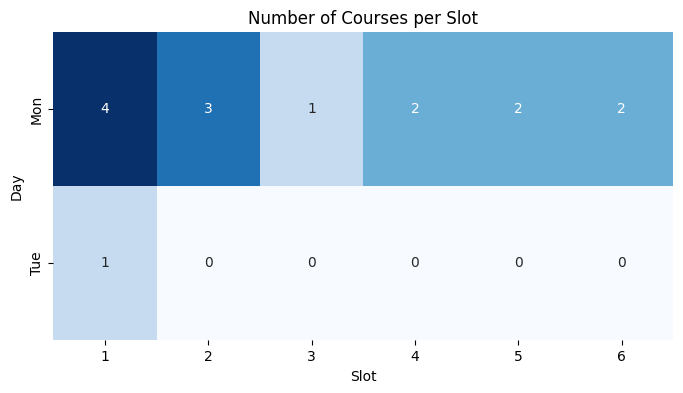

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = timetable.groupby(["Day","Slot"]).size().unstack(fill_value=0)
plt.figure(figsize=(8,4))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", cbar=False)
plt.title("Number of Courses per Slot")
plt.show()